# **Data Science Assignment Zeotap: eCommerce**

##**Clustering**

**Elizabeth Mariya Jose**


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

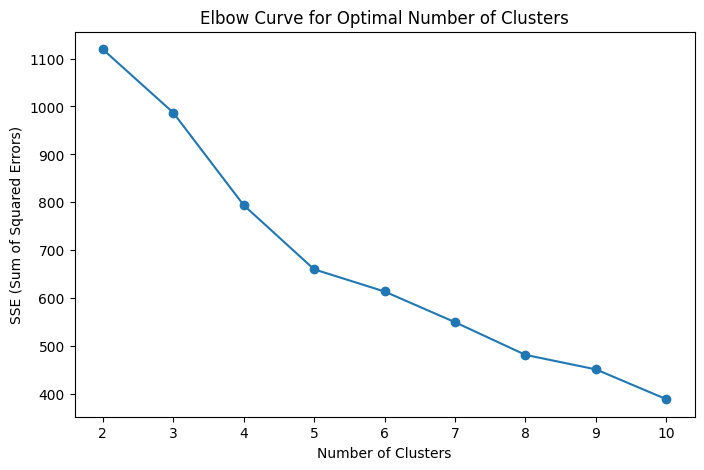

Davies-Bouldin Index: 1.2355554299101352


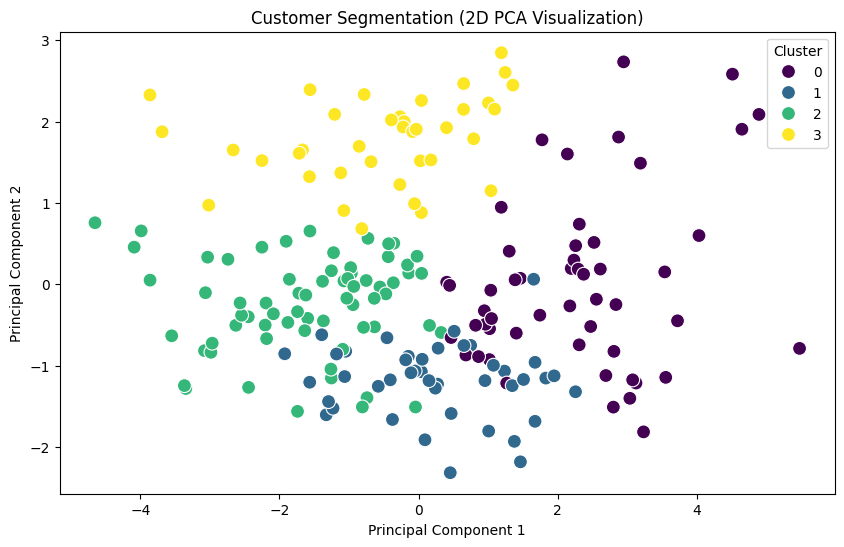

Clustering results saved successfully!


In [4]:
# Preprocess the datasets
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate transaction data to create customer-level features
transaction_features = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    UniqueProducts=('ProductID', 'nunique'),
    AvgTransactionValue=('TotalValue', 'mean'),
    TotalTransactions=('TransactionID', 'count')
).reset_index()

# Merge customer features with the customer profile data
customer_data = pd.merge(customers, transaction_features, on='CustomerID', how='left')

# Fill missing values for customers with no transactions
customer_data.fillna({
    'TotalSpend': 0,
    'TotalQuantity': 0,
    'UniqueProducts': 0,
    'AvgTransactionValue': 0,
    'TotalTransactions': 0
}, inplace=True)


customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)


processed_data = customer_data.drop(columns=['CustomerID', 'CustomerName', 'SignupDate'])

scaler = StandardScaler()
normalized_data = scaler.fit_transform(processed_data)

# Apply clustering
# Choose the number of clusters (k) based on the elbow method
sse = []
k_values = range(2, 11)  # Cluster range: 2 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    sse.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker='o')
plt.title('Elbow Curve for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.show()

# Choose optimal number of clusters (e.g., based on the elbow curve)
optimal_k = 4  # Replace with the number of clusters from the elbow curve

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(normalized_data)

# Add cluster labels to the original dataset
customer_data['Cluster'] = clusters

# Calculate Clustering Metrics
db_index = davies_bouldin_score(normalized_data, clusters)
print(f"Davies-Bouldin Index: {db_index}")

# Visualize Clusters
# Reduce dimensions using PCA for 2D visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=reduced_data[:, 0], y=reduced_data[:, 1],
    hue=customer_data['Cluster'], palette='viridis', s=100
)
plt.title('Customer Segmentation (2D PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

#Save clustering results
customer_data[['CustomerID', 'Cluster']].to_csv('Clustering.csv', index=False)

print("Clustering results saved successfully!")
